Importing librabries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as skl
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_autotune_level=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # optional, hides logs
import tensorflow as tf


Extracting train and test

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Studying the data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59611 entries, 0 to 59610
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   founder_id                  59611 non-null  int64  
 1   founder_age                 59611 non-null  int64  
 2   founder_gender              59611 non-null  object 
 3   years_with_startup          59611 non-null  int64  
 4   founder_role                59611 non-null  object 
 5   monthly_revenue_generated   57811 non-null  float64
 6   work_life_balance_rating    49467 non-null  object 
 7   venture_satisfaction        52447 non-null  object 
 8   startup_performance_rating  59611 non-null  object 
 9   funding_rounds_led          59611 non-null  int64  
 10  working_overtime            59611 non-null  object 
 11  distance_from_investor_hub  59611 non-null  int64  
 12  education_background        59611 non-null  object 
 13  personal_status             596

From above work_life_balance_rating, 

In [46]:
train.describe()

,founder_id,founder_age,years_with_startup,monthly_revenue_generated,funding_rounds_led,distance_from_investor_hub,num_dependents,years_since_founding
count,59611.000000,59611.000000,59611.000000,57811.000000,59611.000000,59611.000000,54831.000000,55427.000000
mean,37224.692171,38.562497,15.752630,7311.070350,0.832514,50.024912,1.648465,55.772909
std,21519.598309,12.082500,11.245724,2197.444033,0.994987,28.519542,1.555767,25.395430
min,1.000000,6.000000,1.000000,1316.000000,0.000000,1.000000,0.000000,2.000000
25%,18576.000000,28.000000,7.000000,5661.000000,0.000000,25.000000,0.000000,36.000000
50%,37207.000000,39.000000,13.000000,7358.000000,1.000000,50.000000,1.000000,56.000000
75%,55874.500000,49.000000,23.000000,8882.000000,2.000000,75.000000,3.000000,76.000000
max,74498.000000,59.000000,51.000000,56050.000000,4.000000,297.000000,6.000000,128.000000


In [47]:
train.isna().sum()/len(train) * 100

founder_id                     0.000000
founder_age                    0.000000
founder_gender                 0.000000
years_with_startup             0.000000
founder_role                   0.000000
monthly_revenue_generated      3.019577
work_life_balance_rating      17.016994
venture_satisfaction          12.017916
startup_performance_rating     0.000000
funding_rounds_led             0.000000
working_overtime               0.000000
distance_from_investor_hub     0.000000
education_background           0.000000
personal_status                0.000000
num_dependents                 8.018654
startup_stage                  0.000000
team_size_category             5.019208
years_since_founding           7.018839
remote_operations              0.000000
leadership_scope               0.000000
innovation_support             0.000000
startup_reputation             0.000000
founder_visibility             0.000000
retention_status               0.000000
dtype: float64

In [48]:
train.nunique()

founder_id                    59598
founder_age                      46
founder_gender                    2
years_with_startup               51
founder_role                      5
monthly_revenue_generated      9545
work_life_balance_rating          4
venture_satisfaction              4
startup_performance_rating        4
funding_rounds_led                5
working_overtime                  2
distance_from_investor_hub      105
education_background              5
personal_status                   3
num_dependents                    7
startup_stage                     3
team_size_category                3
years_since_founding            126
remote_operations                 2
leadership_scope                  2
innovation_support                2
startup_reputation                4
founder_visibility                4
retention_status                  2
dtype: int64

In [4]:
train = train.drop(columns=["founder_id"])

In [5]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train.select_dtypes(include=['object']).columns.drop('retention_status')

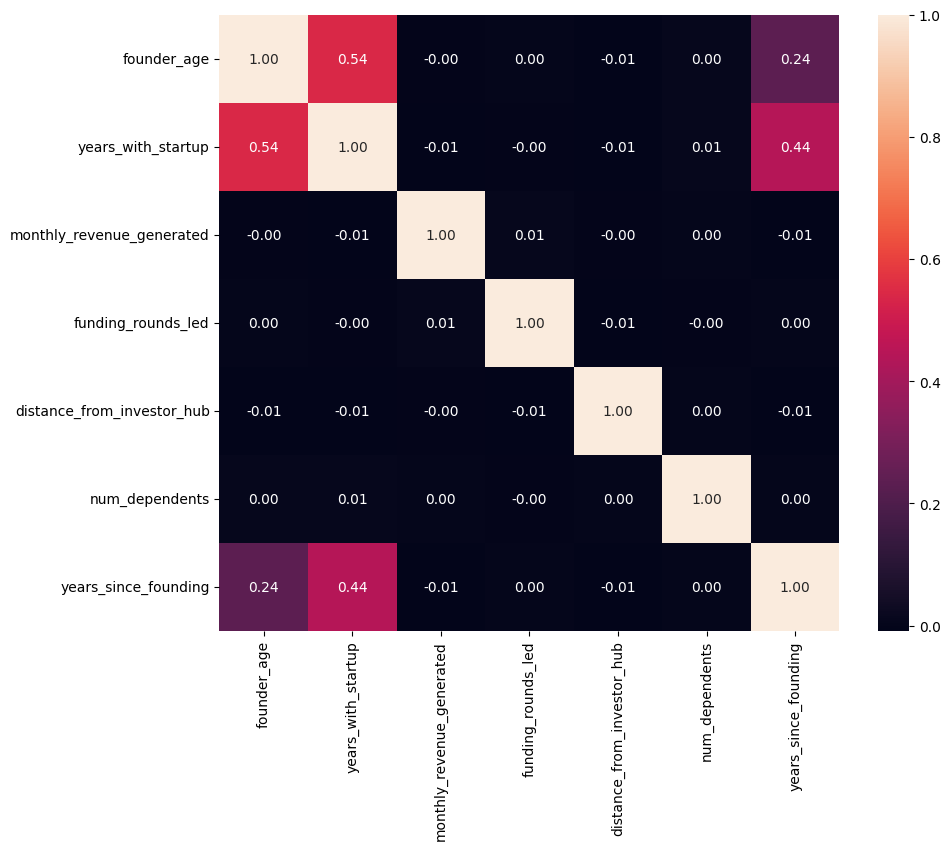

In [6]:
corr_matrix = train[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

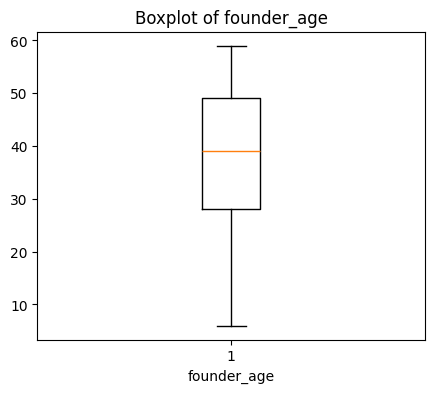

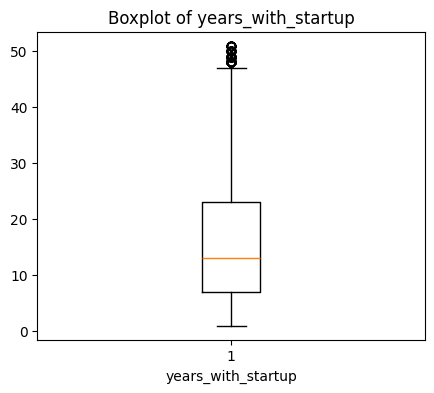

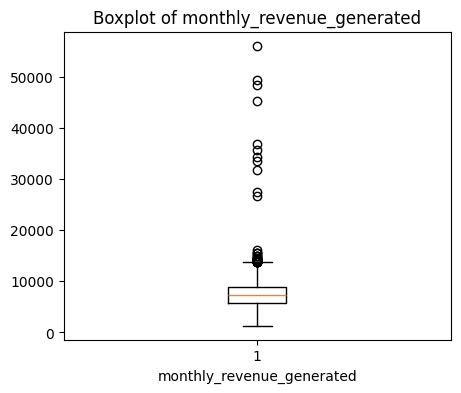

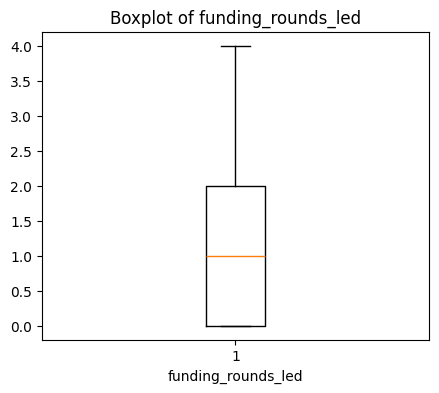

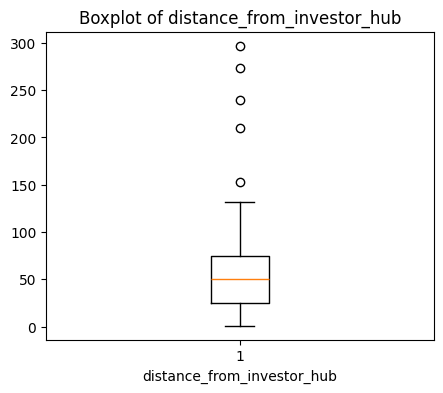

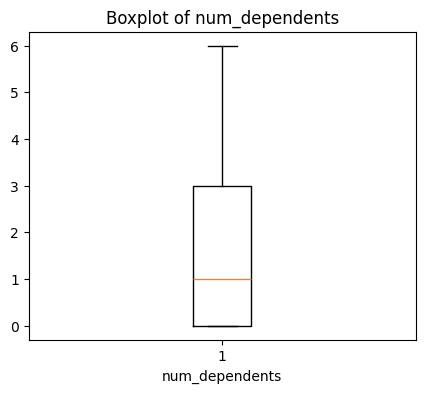

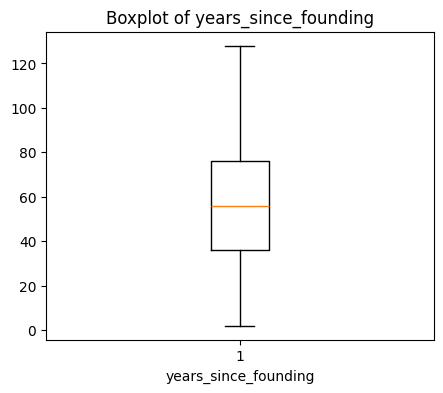

In [7]:
for col in num_cols:
    plt.figure(figsize=(5, 4))
    plt.boxplot(train[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()


Test Train Split

In [7]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, ytrain, yval = train_test_split(train.drop(columns=['retention_status']), train['retention_status'], test_size=0.2, random_state=42)

Pre processor Pipeline

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
yval   = le.transform(yval)


train['retention_status_encoded'] = le.fit_transform(train['retention_status'])



num_with_na = [c for c in num_cols if train[c].isna().any()]
num_no_na = [c for c in num_cols if not train[c].isna().any()]

# categorical handling
special_cat = ['work_life_balance_rating', 'venture_satisfaction']
special_cat = [c for c in special_cat if c in list(cat_cols)]

other_cat = [c for c in cat_cols if c not in special_cat]

# pipelines
numeric_with_na_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

numeric_no_na_pipe = Pipeline([
    ('scaler', RobustScaler())
])

cat_special_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

cat_other_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

# ColumnTransformer
transformers = []
if num_with_na:
    transformers.append(('num_with_na', numeric_with_na_pipe, num_with_na))
if num_no_na:
    transformers.append(('num_no_na', numeric_no_na_pipe, num_no_na))
if special_cat:
    transformers.append(('cat_special', cat_special_pipe, special_cat))
if other_cat:
    transformers.append(('cat_other', cat_other_pipe, other_cat))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop',
    sparse_threshold=0  
)


pre-processor without robust scaler

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
yval   = le.transform(yval)

# also encode full train target for later training
train['retention_status_encoded'] = le.fit_transform(train['retention_status'])



#  PREPROCESSOR 


# identify numeric cols with/without missing values
num_with_na = [c for c in num_cols if train[c].isna().any()]
num_no_na = [c for c in num_cols if not train[c].isna().any()]

# categorical handling
special_cat = ['work_life_balance_rating', 'venture_satisfaction']
special_cat = [c for c in special_cat if c in list(cat_cols)]

other_cat = [c for c in cat_cols if c not in special_cat]

# pipelines
numeric_with_na_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

numeric_no_na_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_special_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

cat_other_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

# ColumnTransformer
transformers = []
if num_with_na:
    transformers.append(('num_with_na', numeric_with_na_pipe, num_with_na))
if num_no_na:
    transformers.append(('num_no_na', numeric_no_na_pipe, num_no_na))
if special_cat:
    transformers.append(('cat_special', cat_special_pipe, special_cat))
if other_cat:
    transformers.append(('cat_other', cat_other_pipe, other_cat))

new_preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop',
    sparse_threshold=0 
)


MLP calassifier with rondomized search 

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint, uniform, loguniform
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


preprocessor.fit(Xtrain)
Xtrain_processed = preprocessor.transform(Xtrain)
Xval_processed   = preprocessor.transform(Xval)


mlp = MLPClassifier(
    activation='relu',
    solver='adam',
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10,
    max_iter=500
)

param_dist = {

   
    "hidden_layer_sizes": [
        (64,), (128,), (256,),
        (128, 64), (256, 128),
        (256, 128, 64),
    ],

 
    "learning_rate_init": loguniform(1e-4, 1e-2),

    "alpha": loguniform(1e-5, 1e-2),

    "batch_size": randint(32, 256),

    "learning_rate": ["adaptive", "constant"]
}


search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=50,      
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(Xtrain_processed, ytrain)

print("="*60)
print("BEST PARAMETERS FOUND:")
print(search.best_params_)
print(f"Best CV Accuracy = {search.best_score_:.4f}")
print("="*60)

y_pred = search.predict(Xval_processed)

print("\nValidation Accuracy:", accuracy_score(yval, y_pred))
print("\nClassification Report:\n", classification_report(yval, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(yval, y_pred))

results = pd.DataFrame(search.cv_results_).sort_values("mean_test_score", ascending=False)
print("\nTop 5 Models:\n")
print(results[[
    "param_hidden_layer_sizes",
    "param_learning_rate_init",
    "param_alpha",
    "param_batch_size",
    "mean_test_score"
]].head(5))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END alpha=2.9380279387035334e-05, batch_size=242, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.005399484409787433; total time=   3.5s
[CV] END alpha=2.9380279387035334e-05, batch_size=242, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.005399484409787433; total time=   3.5s
[CV] END alpha=0.0001329291894316216, batch_size=124, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0015751320499779737; total time=   4.5s
[CV] END alpha=0.0001329291894316216, batch_size=124, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0015751320499779737; total time=   4.6s
[CV] END alpha=0.0001329291894316216, batch_size=124, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0015751320499779737; total time=   4.8s
[CV] END alpha=2.9380279387035334e-05, batch_size=242, hidden_layer_sizes=(256,), learning_rate=adaptive, le

MLP calassifier with grid search

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# fit preprocessor on training data
new_preprocessor.fit(Xtrain)
Xtrain_processed = new_preprocessor.transform(Xtrain)
Xval_processed = new_preprocessor.transform(Xval)

# neural network pipeline with hyperparameter tuning
nn_pipeline = Pipeline([
    ('clf', MLPClassifier(hidden_layer_sizes=(64, 64, 64),
                          activation='relu',
                          solver='adam',
                          random_state=42,
                          max_iter=500))
])

# hyperparameter grid for tuning
param_grid = {
    'clf__hidden_layer_sizes': [(128,128,128)],
    'clf__learning_rate_init': [0.005, 0.01, 0.2],
    'clf__alpha': [0.001, 0.005],
    'clf__batch_size': [64]
}

# GridSearchCV for tuning
grid_search = GridSearchCV(nn_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(Xtrain_processed, ytrain)

print("=" * 60)
print("BEST HYPERPARAMETERS:")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print("=" * 60)

# predictions on validation set
y_pred = grid_search.predict(Xval_processed)

# evaluation metrics
print("\nVALIDATION SET RESULTS:")
print(f"Accuracy: {accuracy_score(yval, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(yval, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(yval, y_pred))

# compare top 5 models
print("\n" + "=" * 60)
print("TOP 5 MODELS FROM GRID SEARCH:")
print("=" * 60)
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df[['param_clf__hidden_layer_sizes', 'param_clf__learning_rate_init', 
                     'param_clf__alpha', 'param_clf__batch_size', 'mean_test_score']].head(5)
print(top_5.to_string())

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(new_preprocessor.transform(train.drop(columns=['retention_status'])), le.fit_transform(train['retention_status']))
# Process test data
test_processed = new_preprocessor.transform(test.drop(columns=['retention_status'], errors='ignore'))

# Make predictions on test set
test_predictions = best_model.predict(test_processed)
test_pred_labels = le.inverse_transform(test_predictions)
# Create submission dataframe
submission = pd.DataFrame({
    'founder_id': test['founder_id'],
    'retention_status': test_pred_labels
})

# Save submission file
submission.to_csv('submission.csv', index=False)

print("=" * 60)
print("SUBMISSION FILE CREATED:")
print("=" * 60)
print(f"Shape: {submission.shape}")
print("\nFirst 5 rows:")
print(submission.head())
print("\nPrediction distribution:")
print(submission['retention_status'].value_counts())
print("\nFile saved as: submission.csv")

using keras library to search

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

new_preprocessor.fit(Xtrain)
Xtrain_processed = new_preprocessor.transform(Xtrain)
Xval_processed = new_preprocessor.transform(Xval)

output_units = 1
final_activation = 'sigmoid'
loss_fn = 'binary_crossentropy'

input_dim = Xtrain_processed.shape[1]

# 1. Define the specific model architecture
model = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(output_units, activation=final_activation)
])

# 2. Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.003), 
    loss=loss_fn,
    metrics=["accuracy"]
)

# 3. Train on the processed training split (with validation)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    Xtrain_processed, ytrain,
    validation_data=(Xval_processed, yval),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Check validation accuracy
val_loss, val_acc = model.evaluate(Xval_processed, yval, verbose=0)
print(f"\nFinal Validation Accuracy: {val_acc:.4f}")

print("\nRetraining on full dataset for submission...")

# Prepare full data
Xtrain_full = preprocessor.fit_transform(train.drop(columns=['retention_status'])).astype("float32")
ytrain_full = le.transform(train['retention_status'])

# Re-build the fresh model to reset weights
final_model = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(output_units, activation=final_activation)
])

final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.003),
    loss=loss_fn,
    metrics=["accuracy"]
)

final_model.fit(
    Xtrain_full, ytrain_full,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    validation_split=0.1, 
    verbose=1
)



test_processed = preprocessor.transform(test.drop(columns=['retention_status'], errors='ignore')).astype("float32")

test_pred_probs = final_model.predict(test_processed)


test_pred = (test_pred_probs.ravel() >= 0.5).astype(int)

test_pred_labels = le.inverse_transform(test_pred)

submission = pd.DataFrame({
    "founder_id": test["founder_id"],
    "retention_status": test_pred_labels
})

submission.to_csv("submission_fixed_layers2.csv", index=False)
print("SUBMISSION CREATED -> submission_fixed_layers.csv")

Trial 65 Complete [00h 00m 13s]
val_accuracy: 0.7446112632751465

Best val_accuracy So Far: 0.7492241859436035
Total elapsed time: 00h 13m 31s

BEST HYPERPARAMETERS FOUND:
Activation: relu
Alpha (L2): 0.0005
Learning Rate: 0.001

Retraining Final Model on FULL dataset with best parameters...
Epoch 1/50
839/839 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7375 - loss: 0.5819 - val_accuracy: 0.7461 - val_loss: 0.5486
Epoch 2/50
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7465 - loss: 0.5311 - val_accuracy: 0.7521 - val_loss: 0.5211
Epoch 3/50
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7497 - loss: 0.5143 - val_accuracy: 0.7565 - val_loss: 0.5094
Epoch 4/50
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 0.5074 - val_accuracy: 0.7538 - val_loss: 0.5070
Epoch 5/50
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 0.5031 - val_accuracy: 0.7476 - val_loss: 0.5089
Epoch 6/50
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7

Keras with Hyperband

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Encode Target
le = LabelEncoder()
y_encoded = ytrain

# Preprocess Features
preprocessor.fit(Xtrain)
Xtrain_processed = preprocessor.transform(Xtrain)
Xval_processed = preprocessor.transform(Xval)

# Define problem type

output_units = 1
final_activation = 'sigmoid'
loss_fn = 'binary_crossentropy'

input_dim = Xtrain_processed.shape[1]


#  DEFINE HYPERMODEL

def build_model(hp):

    activation_choice = hp.Choice('activation', values=['relu', 'gelu', 'tanh'])
    
    
    alpha = hp.Choice('alpha', values=[0.0001, 0.0005, 0.001, 0.005])
    
    
    lr = hp.Choice('learning_rate', values=[0.001, 0.003, 0.005, 0.01])

    
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(input_dim,)))
    
   
    model.add(keras.layers.Dense(
        128, 
        activation=activation_choice, 
        kernel_regularizer=keras.regularizers.l2(alpha)
    ))
    
    
    model.add(keras.layers.Dense(
        64, 
        activation=activation_choice, 
        kernel_regularizer=keras.regularizers.l2(alpha)
    ))
    
    
    model.add(keras.layers.Dense(
        32, 
        activation=activation_choice, 
        kernel_regularizer=keras.regularizers.l2(alpha)
    ))
    

    model.add(keras.layers.Dense(
        16, 
        activation=activation_choice, 
        kernel_regularizer=keras.regularizers.l2(alpha)
    ))

 
    model.add(keras.layers.Dense(output_units, activation=final_activation))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=loss_fn,
        metrics=["accuracy"]
    )
    return model


# RUN HYPERPARAMETER SEARCH

print("\nStarting Hyperparameter Search...")

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='kt_dir',
    project_name='specific_arch_tuning',
    overwrite=True
)

early_stop_tuner = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

tuner.search(
    Xtrain_processed, ytrain,
    validation_data=(Xval_processed, yval),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop_tuner],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


print("BEST HYPERPARAMETERS FOUND:")
print(f"Activation: {best_hps.get('activation')}")
print(f"Alpha (L2): {best_hps.get('alpha')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print("-------------------------------------------------------\n")


print("Retraining ")

# Build the model with the best parameters
final_model = tuner.hypermodel.build(best_hps)


final_model.fit(
    Xtrain, y_encoded,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop_tuner],
    validation_split=0.1, 
    verbose=1
)


# submission file create


test_pred_probs = final_model.predict(Xval_processed)


test_pred = (test_pred_probs.ravel() >= 0.5).astype(int)

test_pred_labels = le.inverse_transform(test_pred)

submission = pd.DataFrame({
    "founder_id": test["founder_id"],
    "retention_status": test_pred_labels
})

submission.to_csv("submission_tuned_128_16.csv", index=False)
print("SUBMISSION CREATED -> submission_tuned_128_16.csv")

Trial 10 Complete [00h 02m 36s]
val_accuracy: 0.7386564016342163

Best val_accuracy So Far: 0.7428499460220337
Total elapsed time: 00h 05m 59s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
0.001             |0.0001            |alpha
0.005             |0.005             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7214 - loss: 0.6156

SVM model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# preprocess
preprocessor.fit(Xtrain)
Xtrain_processed = preprocessor.transform(Xtrain)
Xval_processed   = preprocessor.transform(Xval)

# SVM model
svm_pipeline = Pipeline([
    ('clf', SVC(random_state=42))
])

# search space
param_grid_svm = {
    'clf__kernel': ['rbf', 'poly'],
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 'auto', 0.001, 0.01]
}

# grid search
grid_search_svm = GridSearchCV(
    svm_pipeline,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_svm.fit(Xtrain_processed, ytrain)

print("=" * 60)
print("BEST SVM PARAMS:")
print(grid_search_svm.best_params_)
print(f"Best CV Accuracy: {grid_search_svm.best_score_:.4f}")
print("=" * 60)

# validation evaluation
y_pred_val = grid_search_svm.predict(Xval_processed)
print("\nValidation Accuracy:", accuracy_score(yval, y_pred_val))
print("\nClassification Report:\n", classification_report(yval, y_pred_val))
print("\nConfusion Matrix:\n", confusion_matrix(yval, y_pred_val))

# top 5 models
print("\n" + "=" * 60)
print("TOP 5 SVM MODELS")
print("=" * 60)
results_df = pd.DataFrame(grid_search_svm.cv_results_)
top_5 = results_df[['param_clf__kernel','param_clf__C','param_clf__gamma','mean_test_score']]\
         .sort_values(by='mean_test_score', ascending=False).head(5)
print(top_5.to_string())

# train best model on full data
best_svm = grid_search_svm.best_estimator_
full_X = preprocessor.transform(train.drop(columns=['retention_status']))
full_y = train['retention_status']
best_svm.fit(full_X, full_y)

# test predictions
test_processed = preprocessor.transform(test.drop(columns=['retention_status'], errors='ignore'))
test_preds = best_svm.predict(test_processed)

submission = pd.DataFrame({
    'founder_id': test['founder_id'],
    'retention_status': test_preds
})

submission.to_csv('submission_svm.csv', index=False)

print("=" * 60)
print("SUBMISSION FILE CREATED")
print("=" * 60)
print(submission.head())
print("\nPrediction distribution:\n", submission['retention_status'].value_counts())


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# applying preprocessor

preprocessor.fit(Xtrain)
Xtrain_processed = preprocessor.transform(Xtrain)
Xval_processed = preprocessor.transform(Xval)

ytrain_arr = np.asarray(ytrain)
yval_arr = np.asarray(yval)

# putting in model

log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,                 
    solver="lbfgs",         
    max_iter=500,
    n_jobs=-1
)

log_reg.fit(Xtrain_processed, ytrain_arr)

# Validation 

yval_pred = log_reg.predict(Xval_processed)

acc = accuracy_score(yval_arr, yval_pred)
print("Validation Accuracy:", acc)

print("\nClassification Report:\n")
print(classification_report(yval_arr, yval_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(yval_arr, yval_pred))

# Full data train

preprocessor.fit(train.drop(columns=['retention_status']))
Xtrain_full = preprocessor.transform(train.drop(columns=['retention_status'])).astype("float32")
ytrain_full = le.fit_transform(train['retention_status'])

final_log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=500,
    n_jobs=-1
)

final_log_reg.fit(Xtrain_full, ytrain_full)

# Submission file create


test_processed = preprocessor.transform(
    test.drop(columns=['retention_status'], errors='ignore')
)

test_pred = final_log_reg.predict(test_processed)
test_pred_labels = le.inverse_transform(test_pred)

submission = pd.DataFrame({
    "founder_id": test["founder_id"],
    "retention_status": test_pred_labels
})

submission.to_csv("submission_logreg.csv", index=False)
print("SUBMISSION CREATED → submission_logreg.csv")


Validation Accuracy: 0.7407531661494591

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      5738
           1       0.75      0.75      0.75      6185

    accuracy                           0.74     11923
   macro avg       0.74      0.74      0.74     11923
weighted avg       0.74      0.74      0.74     11923


Confusion Matrix:

[[4184 1554]
 [1537 4648]]
SUBMISSION CREATED → submission_logreg.csv


Checking SVM and NN using 20% of train data

In [10]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, ytrain, yval = train_test_split(train.drop(columns=['retention_status']), train['retention_status'], test_size=0.8, random_state=42)

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# fit preprocessor on training data
preprocessor.fit(Xtrain)
Xtrain_processed = preprocessor.transform(Xtrain)
Xval_processed = preprocessor.transform(Xval)

# neural network pipeline with hyperparameter tuning
nn_pipeline = Pipeline([
    ('clf', MLPClassifier(hidden_layer_sizes=(64, 64, 64),
                          activation='relu',
                          solver='adam',
                          random_state=42,
                          max_iter=500))
])

# hyperparameter grid for tuning
param_grid = {
    'clf__hidden_layer_sizes': [(128,128,128), (64,32,16),(64,32)],
    'clf__learning_rate_init': [0.005, 0.01, 0.2],
    'clf__alpha': [0.001, 0.005],
    'clf__batch_size': [64]
}

# GridSearchCV for tuning
grid_search = GridSearchCV(nn_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(Xtrain_processed, ytrain)

print("=" * 60)
print("BEST HYPERPARAMETERS:")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print("=" * 60)

# predictions on validation set
y_pred = grid_search.predict(Xval_processed)

# evaluation metrics
print("\nVALIDATION SET RESULTS:")
print(f"Accuracy: {accuracy_score(yval, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(yval, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(yval, y_pred))

# compare top 5 models
print("\n" + "=" * 60)
print("TOP 5 MODELS FROM GRID SEARCH:")
print("=" * 60)
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df[['param_clf__hidden_layer_sizes', 'param_clf__learning_rate_init', 
                     'param_clf__alpha', 'param_clf__batch_size', 'mean_test_score']].head(5)
print(top_5.to_string())

Fitting 5 folds for each of 18 candidates, totalling 90 fits
BEST HYPERPARAMETERS:
{'clf__alpha': 0.005, 'clf__batch_size': 64, 'clf__hidden_layer_sizes': (128, 128, 128), 'clf__learning_rate_init': 0.01}
Best CV Accuracy: 0.6961

VALIDATION SET RESULTS:
Accuracy: 0.7006

Classification Report:
              precision    recall  f1-score   support

        Left       0.71      0.63      0.67     22614
      Stayed       0.70      0.76      0.73     25075

    accuracy                           0.70     47689
   macro avg       0.70      0.70      0.70     47689
weighted avg       0.70      0.70      0.70     47689


Confusion Matrix:
[[14281  8333]
 [ 5944 19131]]

TOP 5 MODELS FROM GRID SEARCH:
  param_clf__hidden_layer_sizes  param_clf__learning_rate_init  param_clf__alpha  param_clf__batch_size  mean_test_score
0               (128, 128, 128)                          0.005             0.001                     64         0.690822
1               (128, 128, 128)                      

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

preprocessor.fit(Xtrain)
Xtrain_processed = preprocessor.transform(Xtrain)
Xval_processed   = preprocessor.transform(Xval)

svm_pipeline = Pipeline([
    ('clf', SVC(kernel='rbf', C=10, gamma='scale', random_state=42))
])

svm_pipeline.fit(Xtrain_processed, ytrain)

y_pred_val = svm_pipeline.predict(Xval_processed)

print("\nValidation Accuracy:", accuracy_score(yval, y_pred_val))
print("Validation F1 Score (macro):", f1_score(yval, y_pred_val, average='macro'))
print("\nClassification Report:\n", classification_report(yval, y_pred_val))
print("\nConfusion Matrix:\n", confusion_matrix(yval, y_pred_val))



Validation Accuracy: 0.7139981548268053
Validation F1 Score (macro): 0.713531930117552

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70      5738
           1       0.72      0.73      0.73      6185

    accuracy                           0.71     11923
   macro avg       0.71      0.71      0.71     11923
weighted avg       0.71      0.71      0.71     11923


Confusion Matrix:
 [[4016 1722]
 [1688 4497]]
